In [10]:
JIDT_HOME='/home/jovyan/notebooks/jidt'
DATA_FILENAME=JIDT_HOME + '/demos/data/2coupledRandomCols-1.txt'

In [11]:
#---------------------------------------------------
# START JVM
#-----------------------------------------------------

from jpype import startJVM, isJVMStarted, getDefaultJVMPath, JArray, JInt, JPackage, shutdownJVM, JDouble
import numpy
import sys
# Our python data file readers are a bit of a hack, python users will do better on this:
sys.path.append("/home/jovyan/notebooks/jidt/demos/python")
import readIntsFile, readFloatsFile

# Add JIDT jar library to the path
jarLocation = "/home/jovyan/notebooks/jidt/infodynamics.jar"
# Start the JVM (add the "-Xmx" option with say 1024M if you get crashes due to not enough memory space)
if (not isJVMStarted()):
    startJVM(getDefaultJVMPath(), "-ea", "-Djava.class.path=" + jarLocation)


# 5. Continuous-variable MI in JIDT -- Kernel estimator


In this activity, we continue to analyse the 2coupledRandomCols-1.txt data set   
(which has variable 1 as a noisy lagged copy of Gaussian variable 0).   



In [12]:
# LOAD DATA FILE
#-------------------

import pandas as pd
#from pathlib import Path

filename = DATA_FILENAME
data = pd.read_csv(filename, delim_whitespace=True, comment='%', header=None, names = ['Col0', 'Col1'], index_col=None)
data.head()

,Col0,Col1
0,0.625190,0.000000
1,0.183227,-0.847045
2,-1.029767,0.131580
3,0.949222,-0.989124
4,0.307062,0.680356


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
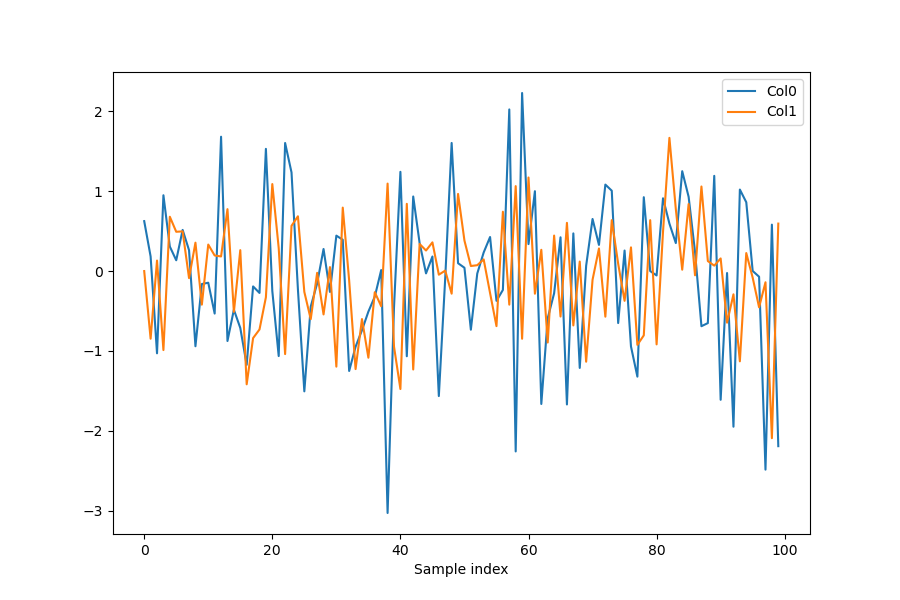

In [13]:
import matplotlib.pyplot as plt
%matplotlib widget

fig, axs = plt.subplots(1, 1, figsize=(9, 6))  
#axs.plot(data['Heart rate'], label='Heart rate')
axs.plot(data['Col0'], label='Col0')
axs.plot(data['Col1'], label='Col1')
#axs.plot(data['Blood oxygen'], label='Blood oxygen')
#axs.set_title('Heart rate, Chest Volume and Blood Oxygen vs Time')
axs.set_xlabel('Sample index')
plt.legend()
plt.show()

In [14]:
# Select data source and destination for MI Estimation
# ----------------------------------------------------

import numpy as np
source = data['Col0'].to_numpy()
destination = data['Col1'].to_numpy()


In [15]:

# # 0. Load/prepare the data:
# dataRaw = readFloatsFile.readFloatsFile(JIDT_HOME + "/demos/data/SFI-heartRate_breathVol_bloodOx-extract.txt")
# # As numpy array:
# data = numpy.array(dataRaw)
# source = data[:,0]
# destination = data[:,1]

In [16]:
# Conversion to Java double array instead of numpy.float
source = JArray(JDouble, 1)(source.tolist())
destination = JArray(JDouble, 1)(destination.tolist())

## Gaussian estimator

In [17]:
# 1. Construct the calculator:
calcClass = JPackage("infodynamics.measures.continuous.gaussian").MutualInfoCalculatorMultiVariateGaussian
calc = calcClass()
# 2. Set any properties to non-default values:
calc.setProperty("TIME_DIFF", "1")
# 3. Initialise the calculator for (re-)use:
calc.initialise()
# 4. Supply the sample data:
calc.setObservations(source, destination)
# 5. Compute the estimate:
result = calc.computeAverageLocalOfObservations()

print("MI_Gaussian(col_0 -> col_1) = %.4f nats" %
    (result))

MI_Gaussian(col_0 -> col_1) = 0.3707 nats


## Kernel estimator

Select Kernel estimator.   
Ensure that the 2coupledRandomCols-1.txt data set is still selected.  

Set the TIME_DIFF parameter to 1 again. (Note these are always reset to defaults when you change the estimator). Leave the KERNEL_WIDTH parameter at its default (0.25).
Press Compute.

Note the answer (it's in bits).

How close is it to the answer we measured (in nats) using the linear-Gaussian estimator?


Why might it be different? Hint: Think about the assumptions of each estimator and their properties.
- dependence on kernel width
- possibility of a strong non linear relationship only detected in the kernel estimator


### Dependence of Kernel Width

You should alter the code template to do this in a for loop, and indeed in Matlab save and plot the results. (Recall that your code needs to call initialise() after setProperty() when changing properties such as the kernel width).
How does the answer vary as a function of the kernel width? How is the question the estimator is asking varying as we change the kernel width? Is there an obvious kernel width that you should use?

In [18]:
# Construct the calculator : MI Kernel Estimator
#-------------------------------------------------

# 1. Construct the calculator:
calcClass = JPackage("infodynamics.measures.continuous.kernel").MutualInfoCalculatorMultiVariateKernel
calc = calcClass()
# 2. Set any properties to non-default values:
calc.setProperty("TIME_DIFF", "1")
calc.setProperty("KERNEL_WIDTH", "0.25")
# 3. Initialise the calculator for (re-)use:
calc.initialise()
# 4. Supply the sample data:
calc.setObservations(source, destination)
# 5. Compute the estimate:
result = calc.computeAverageLocalOfObservations()

print("MI_Kernel(col_0 -> col_1) = %.4f bits" %
    (result))


MI_Kernel(col_0 -> col_1) = 1.0423 bits


## RESULT OF KERNEL ESTIMATOR IS IN BITS !!!!!!!!!!!!!!!!!!!!

Change the kernel width from 0.1 up to 1.0 in increments of 0.05, pressing compute and noting the answer each time.

In [19]:

def kernelEstimator(timediff: int, k: float):
    calc.setProperty("TIME_DIFF", str(timediff))
    calc.setProperty("KERNEL_WIDTH", str(k))
    # 3. Initialise the calculator for (re-)use:
    calc.initialise()
    # 4. Supply the sample data:
    calc.setObservations(source, destination)
    # 5. Compute the estimate:
    result = calc.computeAverageLocalOfObservations()
    return result

   

In [20]:
ks = np.linspace(0.1, 1.1, 20, endpoint=False)
print(ks)

[0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7  0.75
 0.8  0.85 0.9  0.95 1.   1.05]


In [21]:
ks = np.linspace(0.1, 1.1, 20, endpoint=False)
tdiffs = range(50)

KE_Results = np.zeros((len(tdiffs), ks.shape[0]))

for i, tdiff in enumerate(tdiffs):
    for j, k in enumerate(ks):
        KE_Results[i][j]=kernelEstimator(str(tdiff), str(k))


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
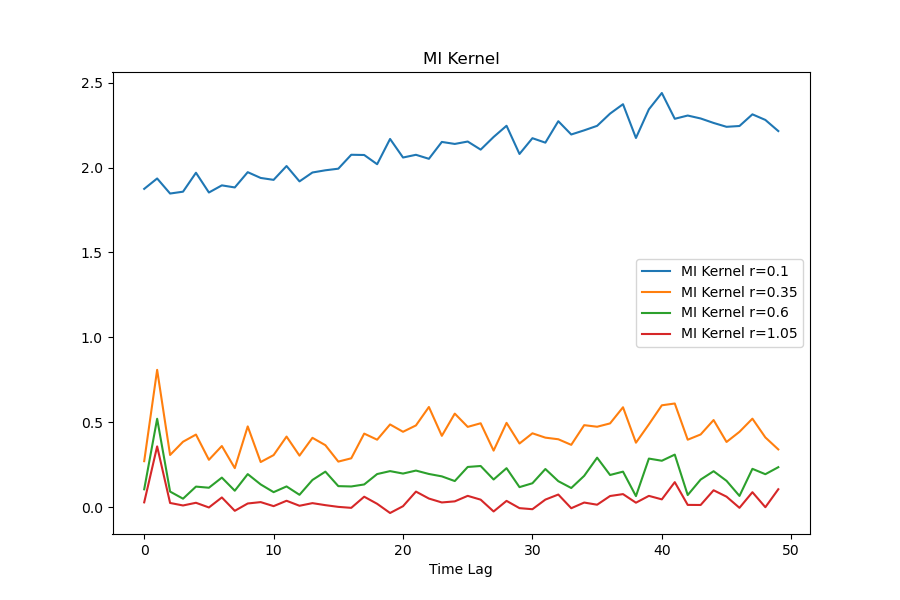

In [22]:
fig, axs = plt.subplots(1, 1, figsize=(9, 6))  
axs.plot(KE_Results[:,0], label='MI Kernel r={}'.format(ks[0]))
axs.plot(KE_Results[:,5], label='MI Kernel r={}'.format(ks[5]))
axs.plot(KE_Results[:,10], label='MI Kernel r={}'.format(ks[10]))
axs.plot(KE_Results[:,19], label='MI Kernel r={}'.format(ks[19]))
axs.set_title('MI Kernel')
axs.set_xlabel('Time Lag')
plt.legend()
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
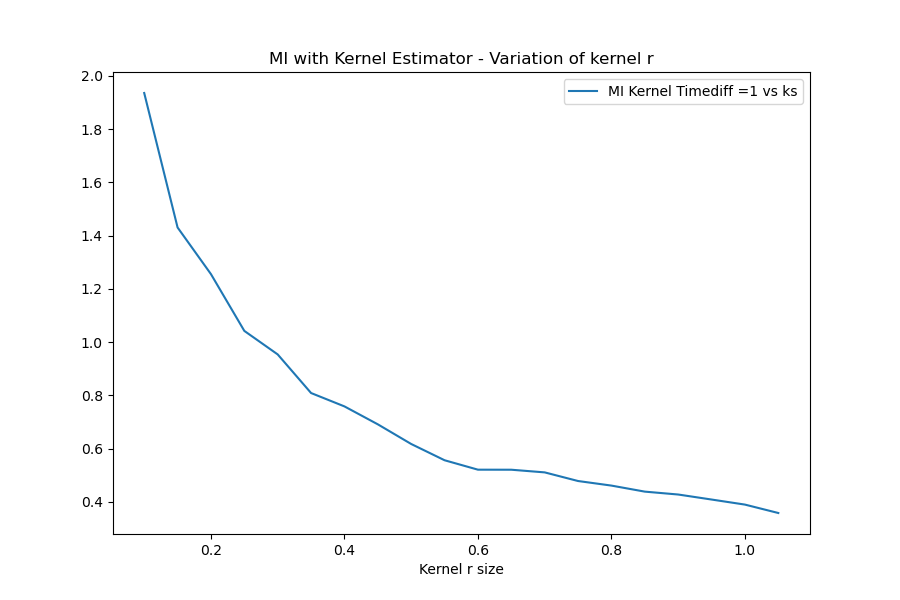

In [23]:
fig, axs = plt.subplots(1, 1, figsize=(9, 6))  
axs.plot(ks, KE_Results[1,:], label='MI Kernel Timediff ={} vs ks'.format(tdiffs[1]))
axs.set_title('MI with Kernel Estimator - Variation of kernel r')
axs.set_xlabel('Kernel r size')
plt.legend()
plt.show()

This dependency to Kernel width is a big problem of that estimator. 


## KRASKOV ESTIMATOR   


The next estimator will find out the width of the box for us, by selecting a fixed number of points in each box (the K nearest neighbours in the joint space).   
So for each sample, then each box will have a different size (smaller when the joint space is more dense, bigger when it is less dense).   
So we are effectively zooming in area with a lot of data to pick up the subtleties.   
And zooming out from areas that are poorly sampled.   

In [24]:
#------------------------------------------
# Estimation with Kraskov KSG Estimator
#------------------------------------------

# 1. Construct the calculator:
calcClass = JPackage("infodynamics.measures.continuous.kraskov").MutualInfoCalculatorMultiVariateKraskov2
calc = calcClass()
# 2. Set any properties to non-default values:
calc.setProperty("k", "4")
# 3. Initialise the calculator for (re-)use:
calc.initialise()
# 4. Supply the sample data:
calc.setObservations(source, destination)
# 5. Compute the estimate:
result = calc.computeAverageLocalOfObservations()

print("MI_Kraskov (KSG) alg. 2(col_0 -> col_1) = %.4f nats" %
    (result))

MI_Kraskov (KSG) alg. 2(col_0 -> col_1) = -0.0574 nats


In [25]:
KSG_results=[]
def ksgEstimator(timediff: int, nearestNeighbors: int = 4):
    calc.setProperty("TIME_DIFF", str(timediff))
    calc.setProperty("k", str(nearestNeighbors))
    # 3. Initialise the calculator for (re-)use:
    calc.initialise()
    # 4. Supply the sample data:
    calc.setObservations(source, destination)
    # 5. Compute the estimate:
    result = calc.computeAverageLocalOfObservations()
    return result

for timediff in range(50):
    result=ksgEstimator(timediff, 4)
    KSG_results.append(result)

ks = list(range(4,15))
print(ks)
KSG_k_results=[]
for k in ks:
    result=ksgEstimator(1, k)
    KSG_k_results.append(result)


[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
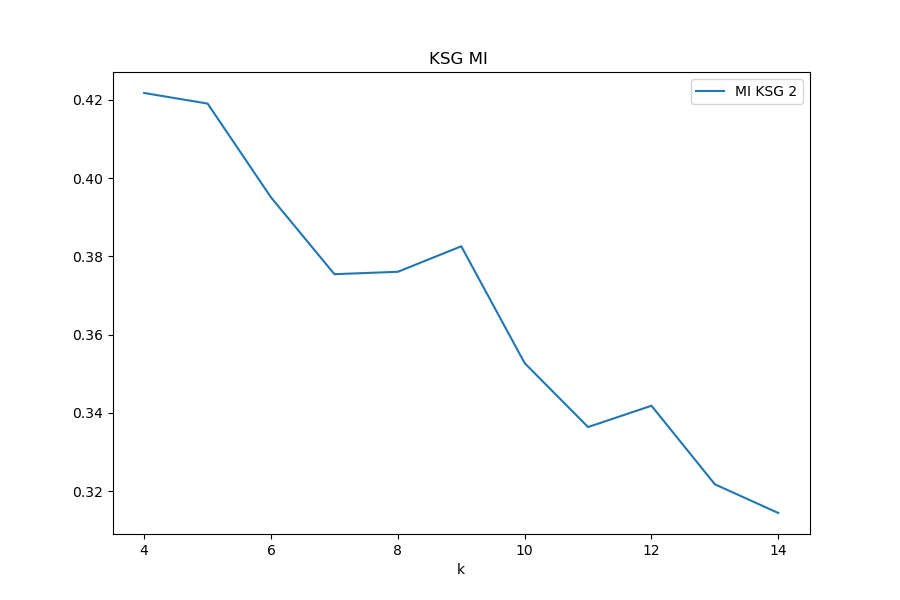

In [26]:
fig, axs = plt.subplots(1, 1, figsize=(9, 6))  
axs.plot(ks, KSG_k_results, label='MI KSG 2')
axs.set_title('KSG MI ')
axs.set_xlabel('k')
plt.legend()
plt.show()

When model estimator like Gaussian shows a large value and one of the model free estimators gives a small value, it may mean there is not enough data for them.    
Since they pick up all sort of relationships, they generally need more data.

If the non linear estimators are bigger than Gaussian, then it means that there is probably a strong non linear relationship between the 2 variables considered.

Those non linear estimators like KSG you can get negative. This is caused by the Bias correction. There is fluctuations around zero because of noise for the mutual information, this fluctuation could bring the estimate for the MI negative.

